## LangGraph 자세히 알아보기
에이전트에 기억력 만들어 주기

In [1]:
from dotenv import load_dotenv
import os

load_dotenv()

True

In [2]:
from typing import Annotated, TypedDict

### 상태 설정

In [3]:
from typing import Annotated, TypedDict
from langgraph.graph.message import add_messages
from langchain_tavily.tavily_search import TavilySearch
from langgraph.prebuilt import ToolNode, tools_condition
from langchain_openai import ChatOpenAI
from langgraph.graph import StateGraph

from langgraph.checkpoint.memory import MemorySaver


### 기억력 만들기

In [4]:
memory = MemorySaver()

In [5]:
class State(TypedDict):
    messages: Annotated[list, add_messages]
    
    
tool = TavilySearch(max_results=2)
tools = [tool]
tool_node = ToolNode(tools)

llm = ChatOpenAI(model= "gpt-4o-mini")
llm_with_tools = llm.bind_tools(tools)

def chatbot(state: State) -> State:
    result = llm_with_tools.invoke(state["messages"])
    return {"messages": [result]}

In [6]:
graph_builder = StateGraph(State)

graph_builder.add_node("chatbot", chatbot)
graph_builder.add_node("tools", tool_node)

graph_builder.add_edge("tools", "chatbot")
graph_builder.add_conditional_edges("chatbot", tools_condition)

graph_builder.set_entry_point("chatbot")
graph = graph_builder.compile(checkpointer=memory)

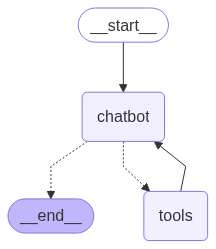

In [7]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

### 테스트 해보기

In [8]:
config = {"configurable": {"thread_id": "1"}}

In [9]:
while True:
    user_input = input("User: ")
    if user_input.lower() in ["quit", "exit", "q"]:
        print("Goodbye!")
        break
    for event in graph.stream({"messages": ("user", user_input)}, config):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)

Assistant: 
Assistant: {"query": "대한민국 대통령", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://ko.wikipedia.org/wiki/%EB%8C%80%ED%95%9C%EB%AF%BC%EA%B5%AD_%EB%8C%80%ED%86%B5%EB%A0%B9", "title": "대한민국 대통령 - 위키백과, 우리 모두의 백과사전", "content": "대통령은 헌법과 법률이 정하는 바에 의하여 국군을 통수한다(헌법 제74조).[8] 다만 군사에 관한 중요사항의 경우 국가안전보장회의의 자문과 국무회의의 심의를 거쳐 국무총리와 관계 국무위원이 부서한 문서로 하여야 하며(헌법 제91조, 제89조 제6호, 제82조), 선전포고나 국군의 외국 파견 등에는 국회의 사전 동의를 필요로 한다(헌법 제60조 제2항). 헌법 제79조 제1항은 “대통령은 법률이 정하는 바에 의하여 사면·감형 또는 복권을 명할 수 있다”, \"일반 사면은 국회의 동의를 거쳐야 한다\"고 하여 대통령의 사면권을 규정하고 있으며, 이에 따라 사면법이 정해져 있다.[11] 대통령은 국정의 중요한 사항에 관한 대통령의 자문에 응하기 위하여 국가원로로 구성되는 국가원로자문회의를 둘 수 있으며(제90조), 평화통일정책의 수립에 관한 대통령의 자문에 응하기 위하여 민주평화통일자문회의(제92조)를 둘 수 있다. 이 직위는 대한민국 헌법 제71조 \"대통령이 궐위되거나 사고로 인하여 직무를 수행할 수 없을 때에는 국무총리, 법률이 정한 국무위원의 순서로 그 권한을 대행한다.\"에 규정되어 있다.", "score": 0.685971, "raw_content": null}, {"url": "https://namu.wiki/w/%EB%8C%80%ED%95%9C%EB%AF%BC%EA%B5%AD%20%EB%8C%80%ED%86%B5%EB%A0%B9", "title": "대한민국 대통령 

In [10]:
snapshot = graph.get_state(config)
snapshot

StateSnapshot(values={'messages': [HumanMessage(content='대한민국 대통력은 누구야?', additional_kwargs={}, response_metadata={}, id='5c4544d1-e315-45d6-ab4d-ef7858585fe3'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_ve5bGXSkf9ucbeQYWc5HuB38', 'function': {'arguments': '{"query":"대한민국 대통령","search_depth":"basic"}', 'name': 'tavily_search'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 23, 'prompt_tokens': 799, 'total_tokens': 822, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_34a54ae93c', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--bc52ed29-9127-4c46-958f-38339afe70eb-0', tool_calls=[{'name': 'tavily_search', 'args': {'query': '대한민국 대통령', 'search_depth': 'basic'}, 'id': 'call_ve5bGXSkf

In [11]:
config2 = {"configurable": {"thread_id": "2"}}
graph.invoke({"messages": [{"role": "user", "content": "내가 한 첫 질문이 뭐였어?"}]},
             config2)

{'messages': [HumanMessage(content='내가 한 첫 질문이 뭐였어?', additional_kwargs={}, response_metadata={}, id='c7e0ebe8-285b-41b6-8dca-9e3f0f9cdb45'),
  AIMessage(content='죄송하지만, 이전 대화 내용을 기억하거나 저장할 수 있는 기능이 없습니다. 따라서 당신의 첫 질문을 알 수 없습니다. 도움이 필요하시면 새로운 질문을 해주시면 좋겠습니다!', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 42, 'prompt_tokens': 800, 'total_tokens': 842, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_34a54ae93c', 'finish_reason': 'stop', 'logprobs': None}, id='run--b0302f37-4f07-424e-9e16-39e8ae5773d3-0', usage_metadata={'input_tokens': 800, 'output_tokens': 42, 'total_tokens': 842, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})]}

### 기억할 메시지 수 제한하기

In [12]:
def filter_messages(messages: list):
    # This is very simple helper function which only ever uses the last message
    return messages[-2:]
    
def chatbot(state: State):
    messages = filter_messages(state["messages"])
    result = llm_with_tools.invoke(messages)
    return {"messages": [result]}

In [13]:
graph_builder = StateGraph(State)

graph_builder.add_node("chatbot", chatbot)
graph_builder.add_node("tools", tool_node)

graph_builder.add_edge("tools", "chatbot")
graph_builder.add_conditional_edges("chatbot", tools_condition)

graph_builder.set_entry_point("chatbot")
graph = graph_builder.compile(checkpointer=memory)

In [14]:
from langchain_core.messages import HumanMessage

config = {"configurable": {"thread_id": "20"}}
input_message = HumanMessage(content="hi! I'm bob and I like soccer")
for event in graph.stream({"messages": [input_message]}, config, stream_mode="values"):
    event["messages"][-1].pretty_print()

# This will now not remember the previous messages
# (because we set `messages[-1:]` in the filter messages argument)
input_message = HumanMessage(content="what's my name?")
for event in graph.stream({"messages": [input_message]}, config, stream_mode="values"):
    event["messages"][-1].pretty_print()

input_message = HumanMessage(content="what's my name?")
for event in graph.stream({"messages": [input_message]}, config, stream_mode="values"):
    event["messages"][-1].pretty_print()
    
input_message = HumanMessage(content="what's my favorite?")
for event in graph.stream({"messages": [input_message]}, config, stream_mode="values"):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

hi! I'm bob and I like soccer
================================== Ai Message ==================================

Hi Bob! It's great to meet a soccer fan! Do you have a favorite team or player? Or is there something specific about soccer you'd like to talk about?
================================ Human Message =================================

what's my name?
================================== Ai Message ==================================

Your name is Bob. How can I assist you today?
================================ Human Message =================================

what's my name?
================================== Ai Message ==================================

Your name is Bob.
================================ Human Message =================================

what's my favorite?
================================== Ai Message ==================================

I don't have information about your personal pre